# Obtain Corrected Photometric Redshifts and Redshift Errors for LADUMA

The idea with this code is to obtain all the corrected redshifts and their errors for Zou+2022 where overlapping LADUMA. Since the calibrations of the corrections may depend on redshift, the strategy is to break the larger file into multiple redshifts windows, then derive and apply the corrections, before rejoining all the windows.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(70.,0.3,0.7)
from copy import deepcopy
from astropy.stats import biweight_scale

from matplotlib.ticker import MaxNLocator, AutoLocator
from matplotlib import rcParams
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 9
rcParams['ytick.labelsize'] = 9
rcParams['legend.fontsize'] = 9
rcParams['font.family'] = 'sans-serif'
rcParams['grid.color'] = 'k'
rcParams['grid.linewidth'] = 0.2
my_locator = MaxNLocator(6)
singlecolsize = (3.3522420091324205, 2.0717995001590714)
doublecolsize = (7.500005949910059, 4.3880449973709)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def bin_bootstrap(vals):
    nbs = 5000
    data = np.random.choice(vals, size=(len(vals),5000))
    return np.std(np.median(data,axis=0))

mad = lambda xx: np.median(np.abs(xx-np.median(xx)))
def bin_bootstrap_mad(vals):
    nbs = 5000
    data = np.random.choice(vals, size=(len(vals),5000))
    return np.std([mad(row) for row in data])

In [2]:
def get_photz_corrections(photz,qz, photzerr, specz, rmag, showplots=True):
    photz=np.array(photz)
    photzerr=np.array(photzerr)
    specz=np.array(specz)
    qz = np.array(qz)
    rmag=np.array(rmag)
    depth = get_photoz_depth(photz,qz,rmag,showplots)
    print('DEPTH: ', depth)
    calibration_sel = ~np.isnan(photz) & ~np.isnan(specz) & (specz!=0) & (rmag!=0) & ~np.isnan(rmag) & (photzerr!=0)
    photz_for_cal = photz[calibration_sel]
    specz_for_cal = specz[calibration_sel]
    photzerr_for_cal = photzerr[calibration_sel]
    rmag_for_cal = rmag[calibration_sel]
    print("calibration size: ", len(photz_for_cal))
    #bins = np.arange(int(np.min(rmag_for_cal)+0.5), int(np.max(rmag_for_cal)-0.5), 1.5)
    bins = np.arange(int(np.percentile(rmag_for_cal,5)), int(np.percentile(rmag_for_cal, 95))+1, 1)
    zphot_correction_function = correct_photz_values(photz_for_cal, specz_for_cal, rmag_for_cal, bins, depth, showplots)
    photzcorr = photz - zphot_correction_function(rmag)
    # print('nan in photz?', np.isnan(photz).any())
    # print('nan in correction func?', np.isnan(zphot_correction_function(rmag)).any())
    # print('nan in rmag?', np.isnan(rmag).any())
    photzcorr_for_cal = photzcorr[calibration_sel]
    etab_correction_function = correct_photz_errors(photzcorr_for_cal, photzerr_for_cal, specz_for_cal, rmag_for_cal, bins, depth, showplots)
    photzerrcorr = photzerr * etab_correction_function(rmag)
    return photzcorr, photzerrcorr

def correct_photz_values(photz,specz,rmag,magbins,depth,showplots):
    values = photz - specz
    median,bedges,_ = binned_statistic(rmag, values, statistic='median', bins=magbins)
    pt16,_,_ = binned_statistic(rmag, values, statistic=lambda x:np.median(x)-np.percentile(x,16), bins=magbins)
    pt84,_,_ = binned_statistic(rmag, values, statistic=lambda x:np.percentile(x,84)-np.median(x), bins=magbins)
    mederr,_,_= binned_statistic(rmag, values, statistic=bin_bootstrap, bins=magbins)
    binc = 0.5*(bedges[1:]+bedges[:-1])
    fitsel = (binc<depth)
    popt = np.polyfit(binc[fitsel],median[fitsel],w=1/np.sqrt(pt16*pt16+pt84*pt84)[fitsel], deg=1)
    ft_fun = lambda rr: np.polyval(popt,rr)
    if showplots==True:
        plt.figure()
        plt.scatter(rmag, values, color='cornflowerblue',alpha=0.5,s=1)
        plt.errorbar(binc,median,yerr=[pt16,pt84],color='k', capsize=6,label='Median (16th, 84th %ile)',linestyle='None',marker='.')
        plt.errorbar(binc,median,yerr=mederr,color='k', capsize=2,label=r'Median $\pm$ Bootstrapped Error',linestyle='None',marker='None')
        plt.plot(binc,np.polyval(popt,binc),color='red')
        plt.ylabel(r'$\Delta z$')
        plt.xlabel('r-band apparent mag')
        plt.title(r'$\Delta z$ Distribution (uncorrected)'+'\nmedian = {:0.5f} / MAD = {:0.2f}'.format(np.median(values), mad(values)))
        plt.grid(alpha=0.3)
        plt.ylim(-1,1)
        plt.legend(loc='upper right')
        plt.show()
    elif hasattr(showplots,'plot'):
        showplots.scatter(rmag, values, color='cornflowerblue',alpha=0.5,s=3,zorder=0)
        #showplots.errorbar(binc,median,yerr=[pt16,pt84],color='k', capsize=6,label='Median (16th, 84th %ile)',linestyle='None',marker='.')
        showplots.errorbar(binc,median,yerr=mederr,color='k', capsize=2,label=r'Median',linestyle='None',marker='None',zorder=3)
        showplots.plot(binc,np.polyval(popt,binc),color='red', label='Linear Model',zorder=1)
        showplots.set_ylabel(r'$\Delta z$')
        showplots.set_xlabel('r-band apparent mag')
        #showplots.title(r'$\Delta z$ Distribution (uncorrected)'+'\nmedian = {:0.5f} / MAD = {:0.2f}'.format(np.median(values), mad(values)))
        showplots.grid(alpha=0.3)
        showplots.set_ylim(-1,1)
        showplots.legend(loc='best',fontsize=9)
    return ft_fun

def correct_photz_errors(photzcorr, photzerr, specz, rmag, magbins, depth, showplots):
    values = (photzcorr - specz) / photzerr
    madvalue,bedges,_ = binned_statistic(rmag, values, statistic=mad, bins=magbins)
    maderr,_,_= binned_statistic(rmag, values, statistic=bin_bootstrap_mad, bins=magbins)
    binc = 0.5*(bedges[1:]+bedges[:-1])
    fitsel = (binc<depth)
    popt = np.polyfit(binc[fitsel],madvalue[fitsel],w=1/maderr[fitsel], deg=2)
    ft_fun = lambda rr: np.polyval(popt,rr)
    if showplots==True:
        plt.figure()
        plt.errorbar(binc,madvalue,yerr=maderr,color='k', capsize=2,label=r'Median $\pm$ Bootstrapped Error',linestyle='None',marker='None')
        plt.plot(binc,np.polyval(popt,binc),color='red')
        plt.ylabel(r'BW Scale [$\Delta z_{\rm corr}/e_{\rm tab}$]')
        plt.xlabel('r-band apparent mag')
        #plt.title(r'$\Delta z_{\$ Distribution (uncorrected)'+'\nmedian = {:0.5f} / MAD = {:0.2f}'.format(np.median(values), mad(values)))
        plt.grid(alpha=0.3)
        plt.ylim(-1,1)
        plt.legend(loc='best')
        plt.show()
    elif hasattr(showplots, 'plot'):
        showplots.errorbar(binc,madvalue,yerr=maderr,color='k', capsize=2,label=r'Scale Factor', linestyle='None',marker='None',zorder=1)
        showplots.plot(binc,np.polyval(popt,binc),color='red',zorder=0, label='Quadratic Fit')
        #showplots.set_ylabel(r'MAD [$\Delta z_{\rm corr}/e_{\rm tab}$]')
        #showplots.set_xlabel('r-band apparent mag')
        #showplots.title(r'$\Delta z_{\$ Distribution (uncorrected)'+'\nmedian = {:0.5f} / MAD = {:0.2f}'.format(np.median(values), mad(values)))
        #showplots.grid(alpha=0.3)
        showplots.set_ylim(-1,1)
        showplots.legend(loc='best',fontsize=9)
    return ft_fun
    

def get_photoz_depth(zphot, qz, rmag, showplots):
    sel = ~np.isnan(zphot) & ~np.isnan(qz) & ~np.isnan(rmag)
    zphot=np.array(zphot)[sel]
    qz = np.array(qz)[sel]
    rmag = np.array(rmag)[sel]
    pimg = np.where(qz<1, 1, 0).astype(int)
    popt,pcov = curve_fit(photz_logistic_fn, rmag, pimg, p0=[0.5,2,22,0.5])
    if showplots==True:
        plt.figure()
        plt.plot(rmag, pimg,'k.', alpha=0.2)
        tx=np.linspace(np.min(rmag),np.max(rmag),1000)
        plt.plot(tx, photz_logistic_fn(tx,*popt), color='red')
        plt.axvline(popt[2],color='blue')
        plt.title(popt)
        plt.show()

        plt.figure()
        plt.plot(rmag, qz, 'k.')
        plt.ylim(0,5)
        plt.show()
    depth = popt[2]
    return depth
    

def photz_logistic_fn(rmag, a1, a2, a3, a4):
    return a4 + a1/(1+np.exp(a2*(rmag-a3)))

NOTE: some zphotcorr + zphotcorrerr come out as NaN because there is no r-band apparent magnitude

## Obtain Subsamples

In [3]:
#data = pd.read_csv("subsampletest.csv")
#assert False, "this file was accidentally was written over; start over from beginning"
data = pd.read_hdf('./zou/xmmservs_laduma_merged_noabsmag.hdf5', key='df')

## Get combined best specz

In [4]:
combinedzspec = data.ZBESTNEW_zspecfile.to_numpy()
combinedzspecerr = data.ZERRNEW_zspecfile.to_numpy()
zspecxmm = data.zspec.to_numpy()
sel = np.where(np.isnan(combinedzspec))
combinedzspec[sel] = zspecxmm[sel]
data.loc[:,'combinedzspec'] = combinedzspec
data.loc[:,'combinedzspecerr'] = combinedzspecerr
np.sum(np.isnan(combinedzspec))

762108

In [5]:
data.loc[:,'zphoterr'] = np.sqrt((data.pz_ulim-data.zphot)**2 + (data.zphot-data.pz_llim)**2)

In [6]:
# (data.combinedzspecerr / data.combinedzspec).describe()

## Get photz and error corrections

In [7]:
window_bins = np.arange(0.1,1.4,0.1)
data.loc[:,'zphotbinid'] = np.digitize(data.zphot,bins=window_bins)
subsamples = [grp for (_,grp) in data.groupby('zphotbinid')]

## Apply Photometric Redshift Corrections to each subsample

WORKING ON SUBSAMPLE 0 ----------------------------


/afs/cas.unc.edu/users/z/h/zhutchen/.conda/envs/astro2/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


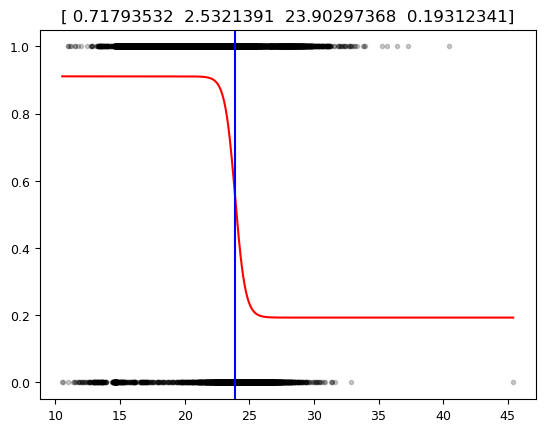

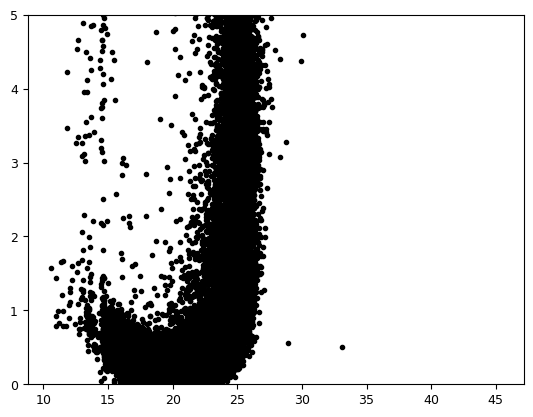

DEPTH:  23.902973676756574
calibration size:  1577


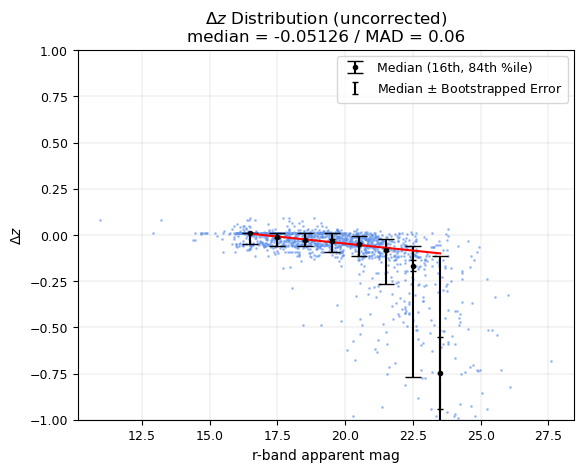

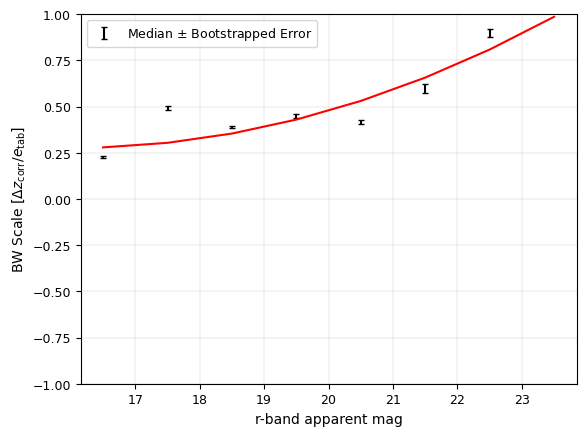

WORKING ON SUBSAMPLE 1 ----------------------------


/afs/cas.unc.edu/users/z/h/zhutchen/.conda/envs/astro2/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


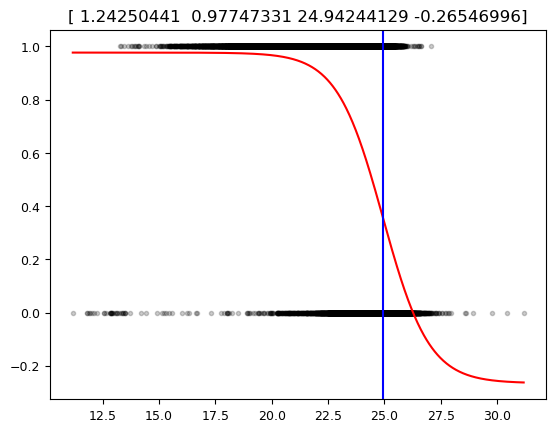

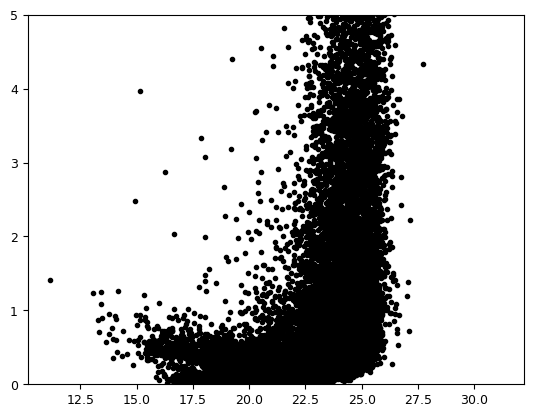

DEPTH:  24.942441286954356
calibration size:  3691


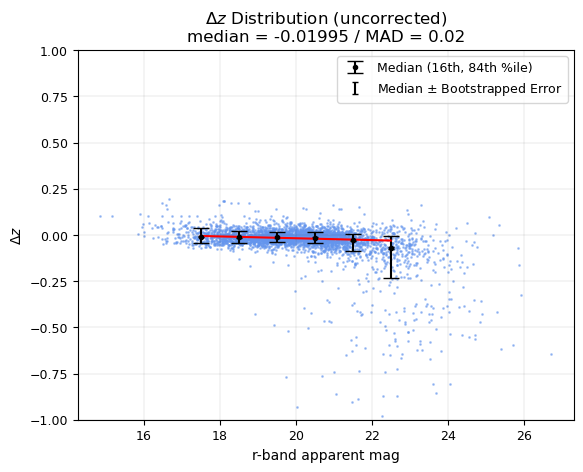

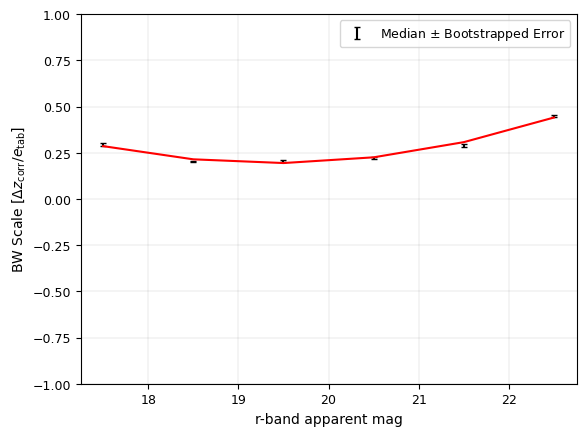

WORKING ON SUBSAMPLE 2 ----------------------------


/afs/cas.unc.edu/users/z/h/zhutchen/.conda/envs/astro2/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


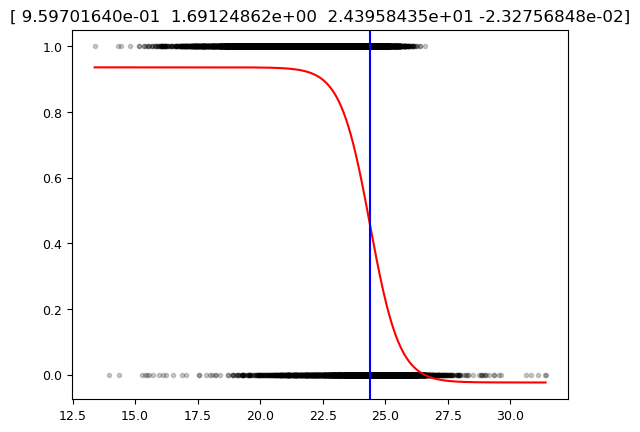

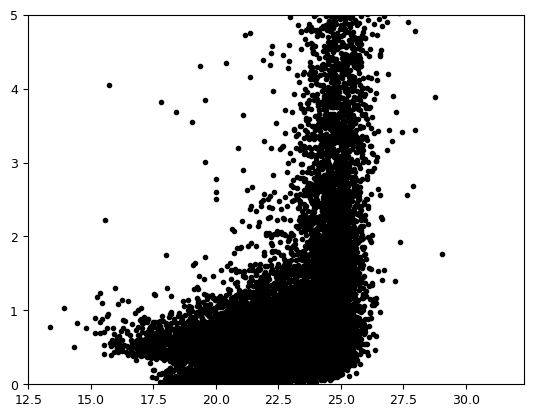

DEPTH:  24.395843527297945
calibration size:  2741


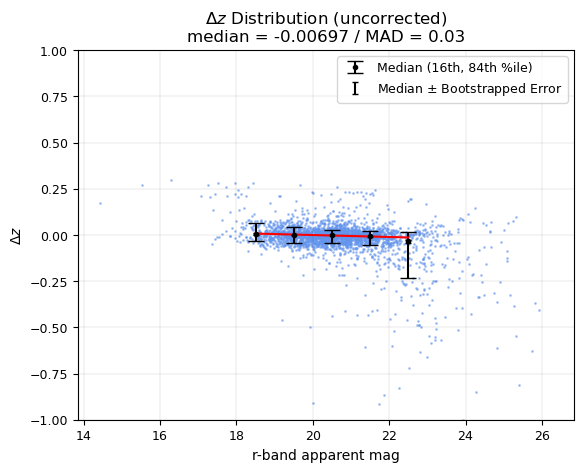

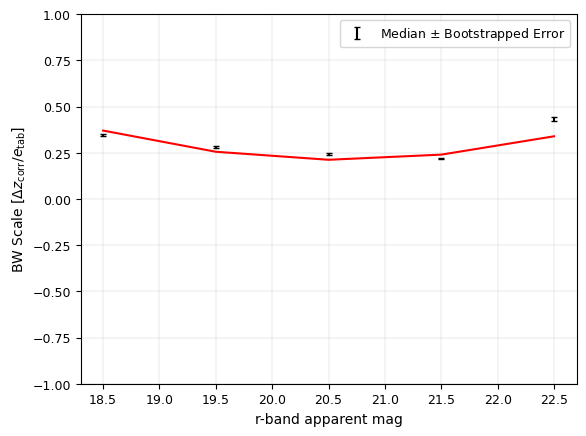

WORKING ON SUBSAMPLE 3 ----------------------------


/afs/cas.unc.edu/users/z/h/zhutchen/.conda/envs/astro2/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


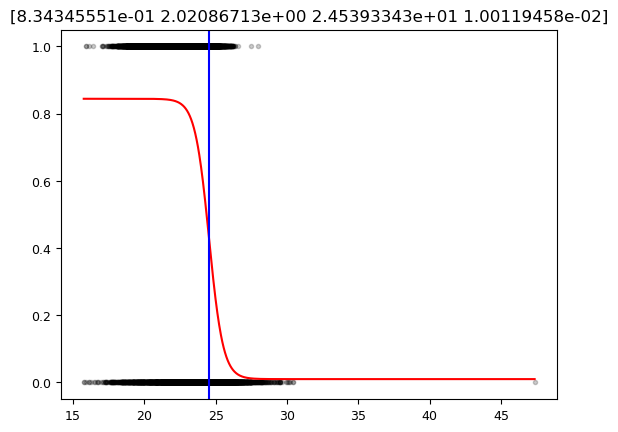

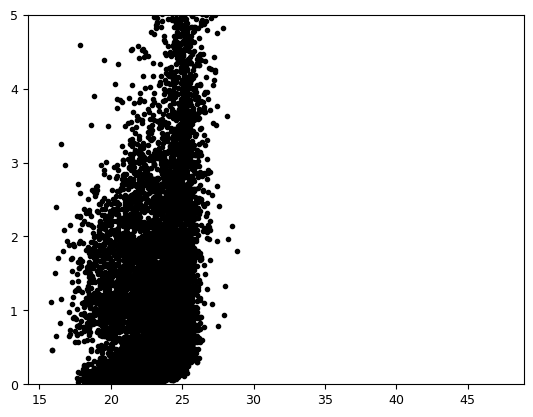

DEPTH:  24.53933428780473
calibration size:  3488


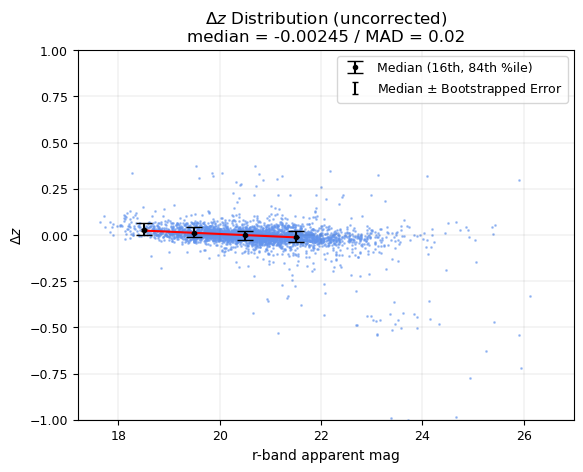

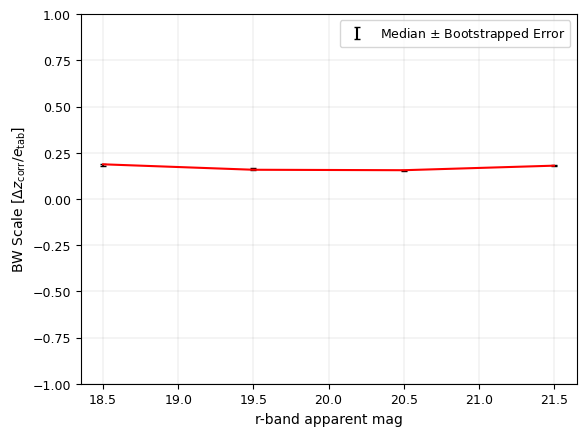

WORKING ON SUBSAMPLE 4 ----------------------------


/afs/cas.unc.edu/users/z/h/zhutchen/.conda/envs/astro2/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


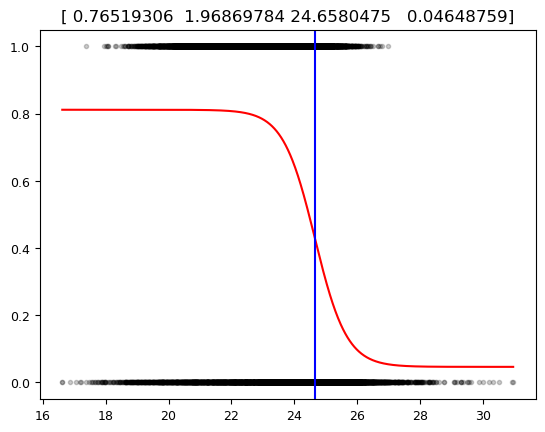

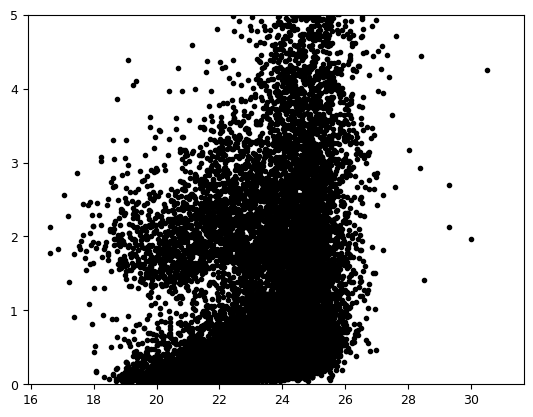

DEPTH:  24.658047503857233
calibration size:  2892


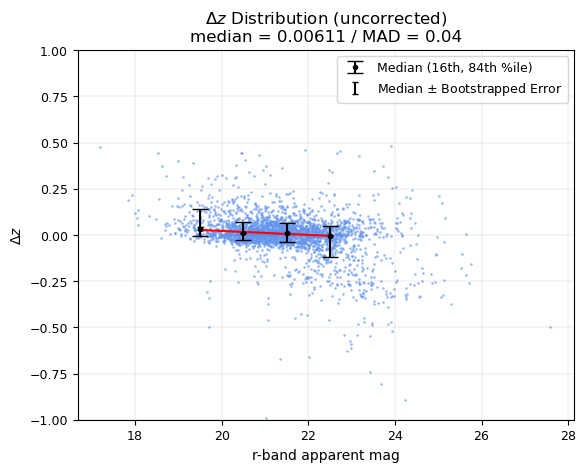

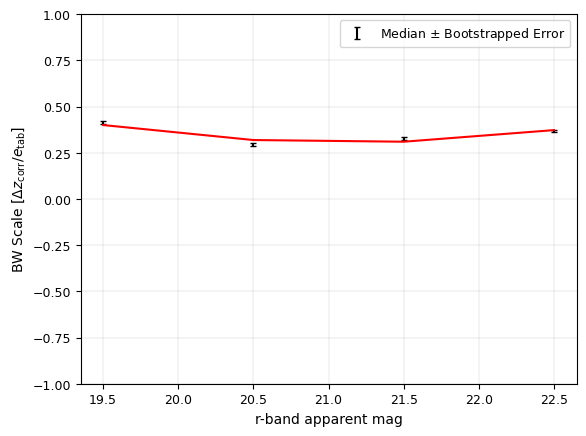

WORKING ON SUBSAMPLE 5 ----------------------------


/afs/cas.unc.edu/users/z/h/zhutchen/.conda/envs/astro2/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


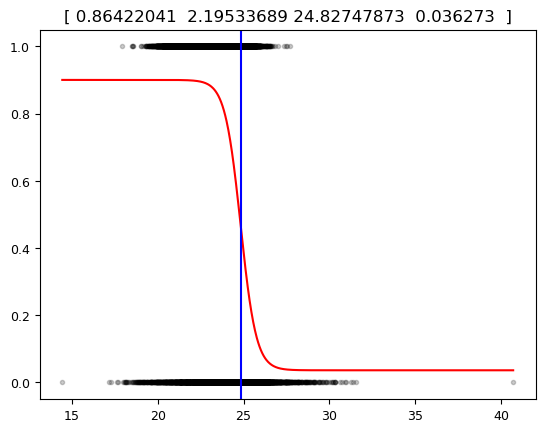

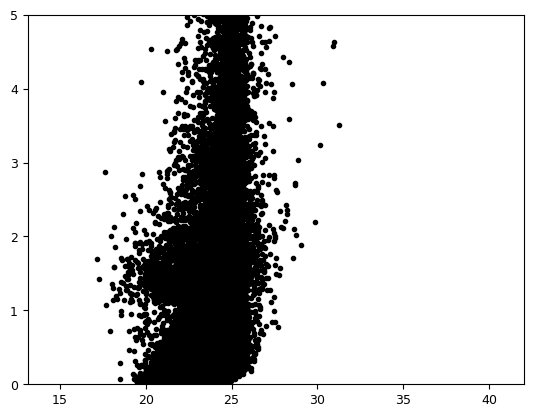

DEPTH:  24.827478734910024
calibration size:  4722


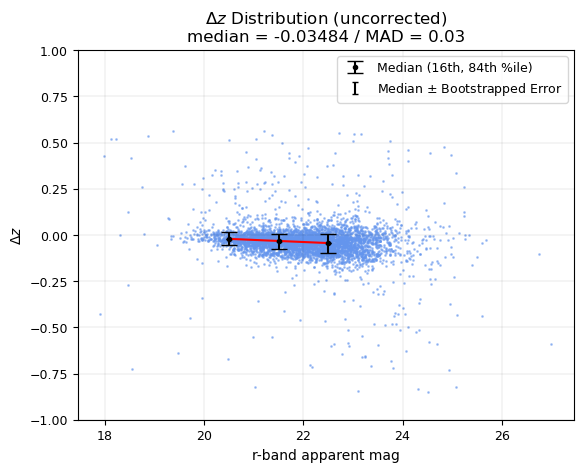

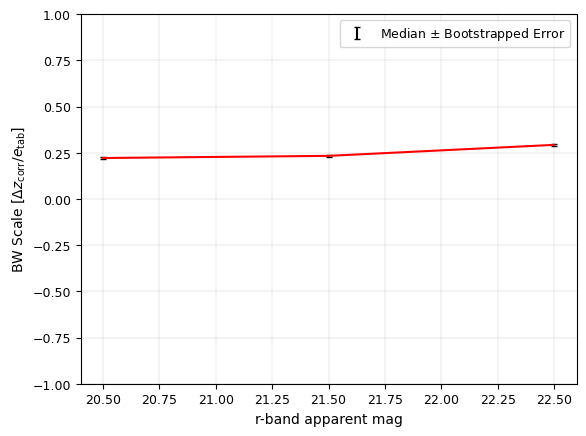

WORKING ON SUBSAMPLE 6 ----------------------------


/afs/cas.unc.edu/users/z/h/zhutchen/.conda/envs/astro2/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


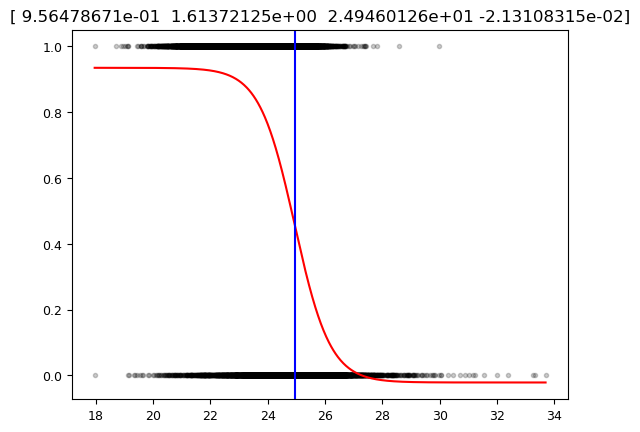

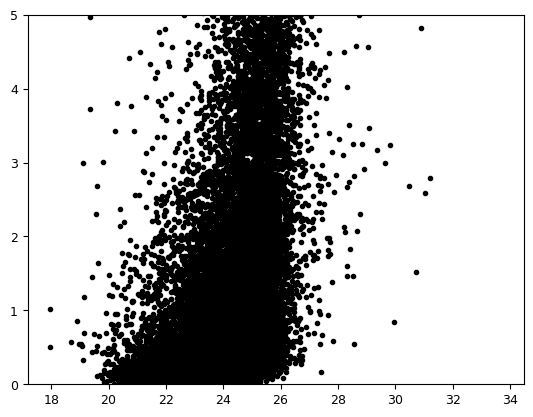

DEPTH:  24.946012632993934
calibration size:  3670


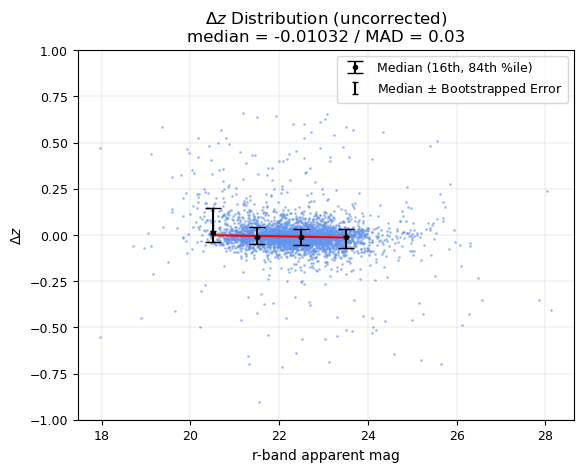

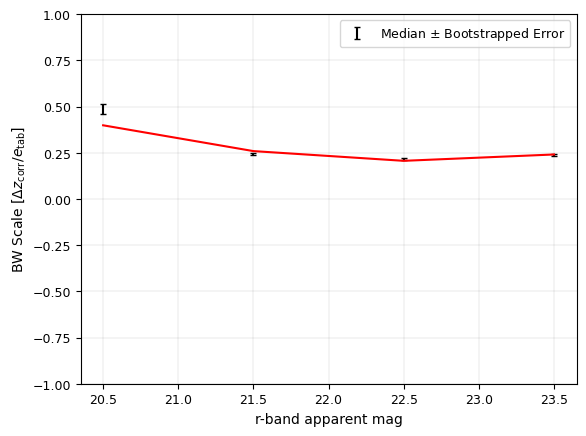

WORKING ON SUBSAMPLE 7 ----------------------------


/afs/cas.unc.edu/users/z/h/zhutchen/.conda/envs/astro2/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


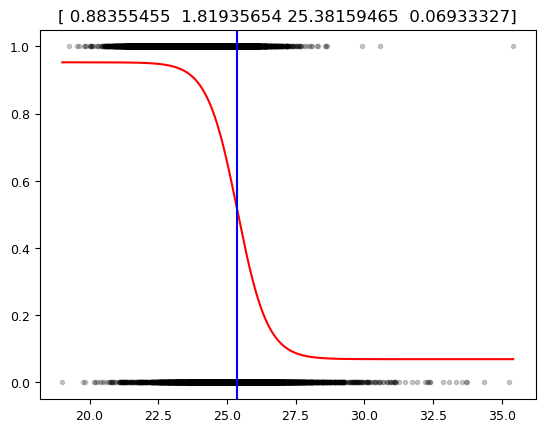

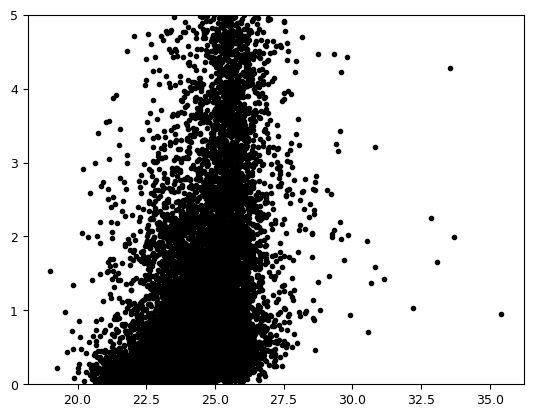

DEPTH:  25.381594649992447
calibration size:  3097


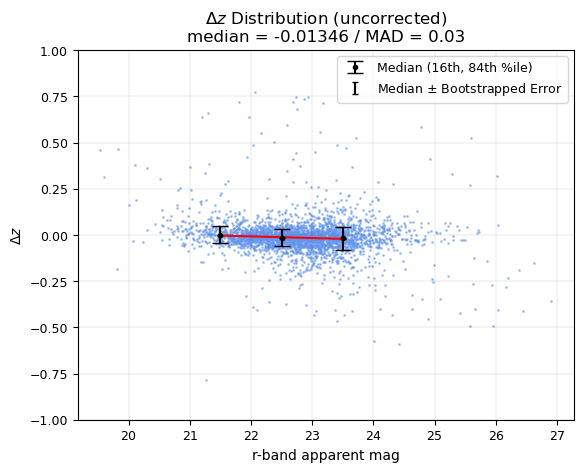

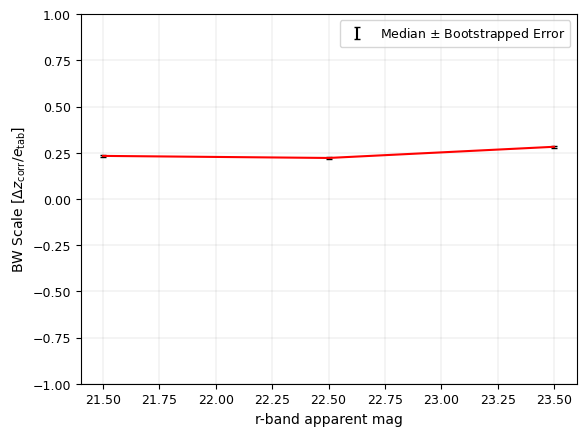

WORKING ON SUBSAMPLE 8 ----------------------------


/afs/cas.unc.edu/users/z/h/zhutchen/.conda/envs/astro2/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


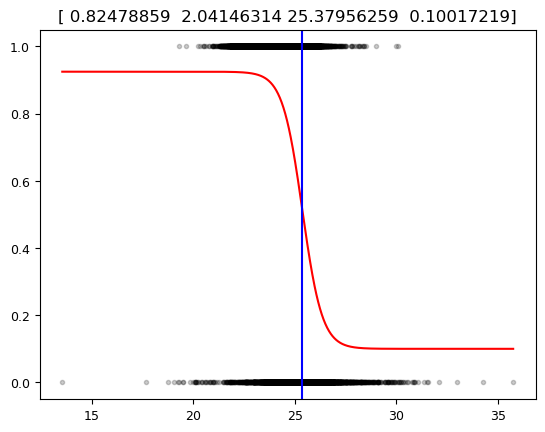

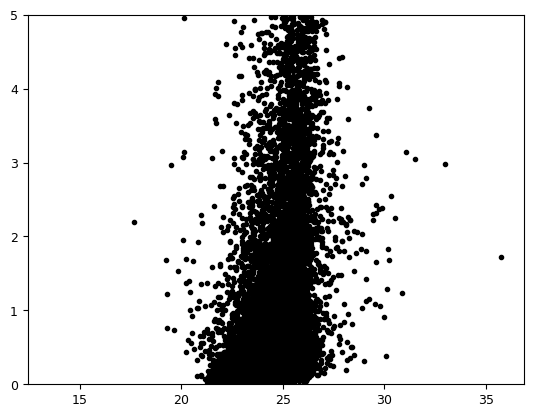

DEPTH:  25.37956259391459
calibration size:  1271


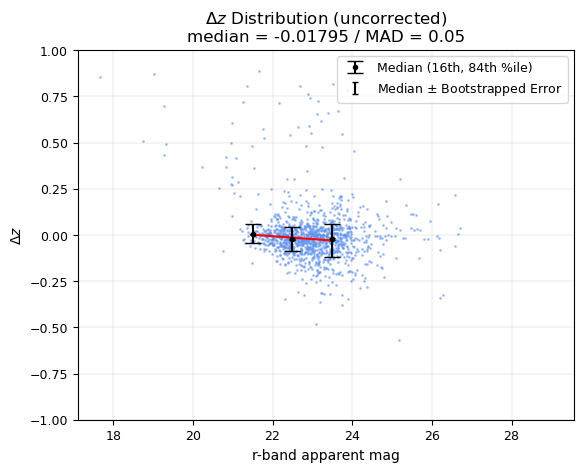

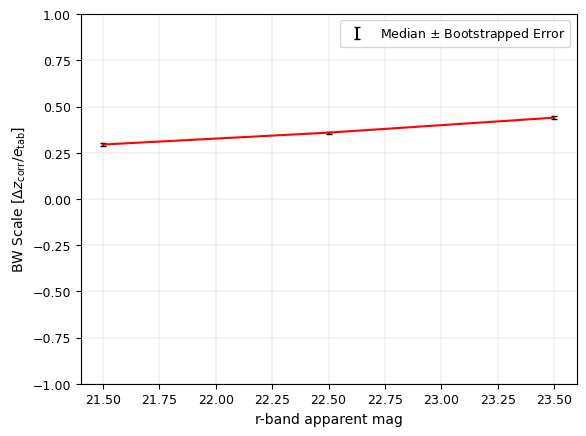

WORKING ON SUBSAMPLE 9 ----------------------------


/afs/cas.unc.edu/users/z/h/zhutchen/.conda/envs/astro2/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


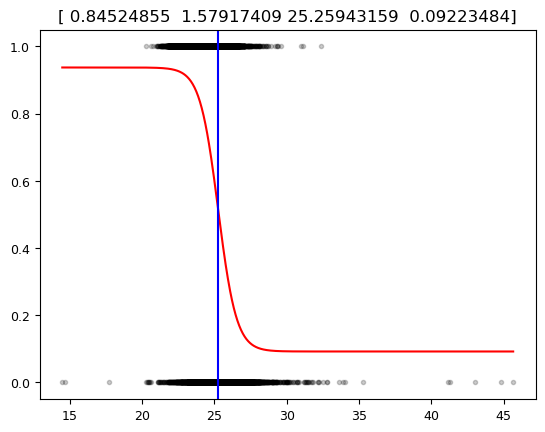

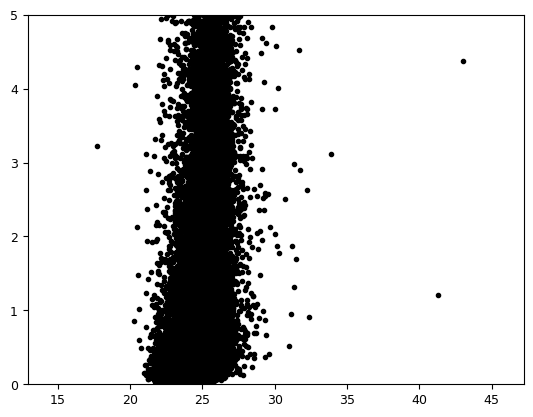

DEPTH:  25.259431593073273
calibration size:  1344


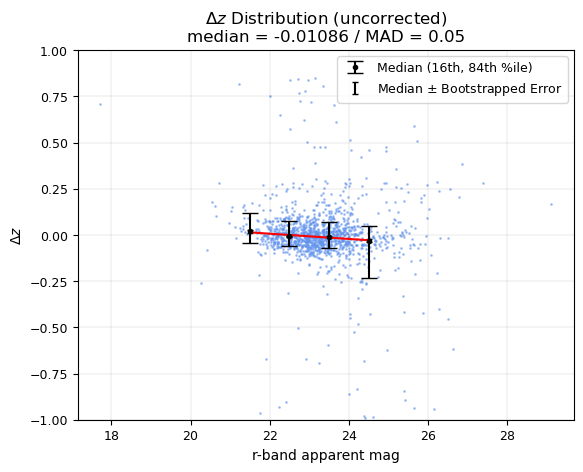

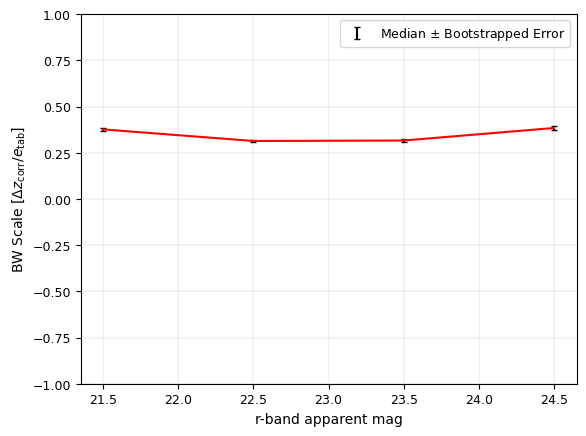

WORKING ON SUBSAMPLE 10 ----------------------------


/afs/cas.unc.edu/users/z/h/zhutchen/.conda/envs/astro2/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


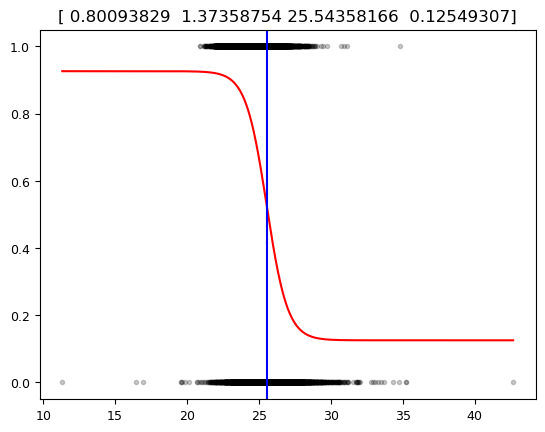

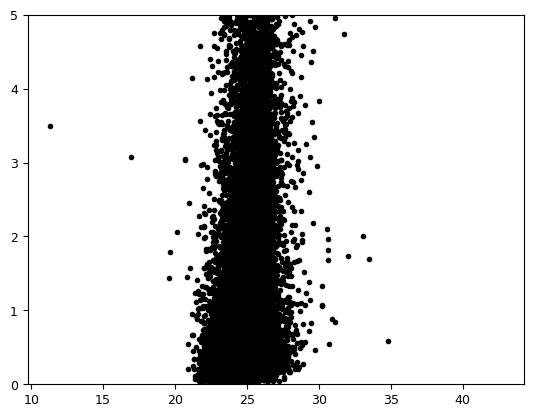

DEPTH:  25.543581662424774
calibration size:  1083


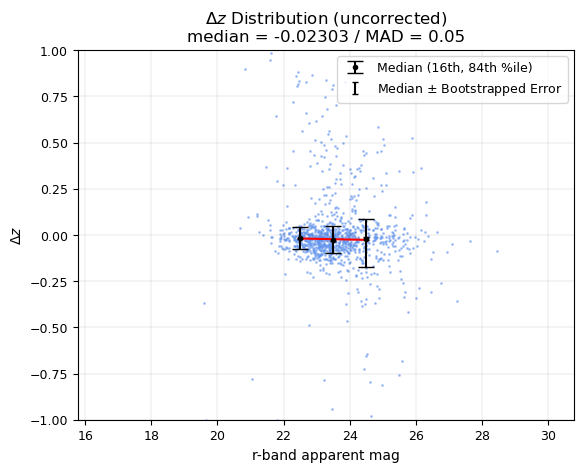

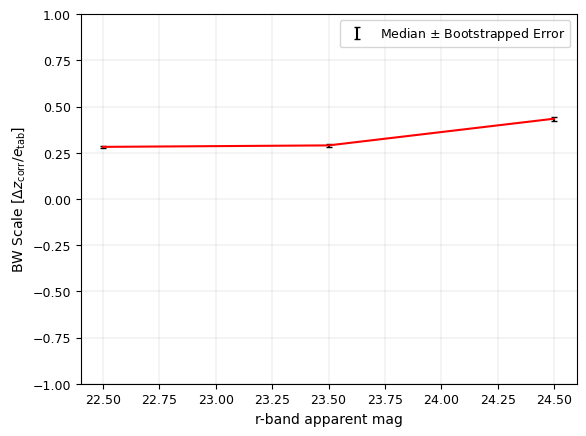

WORKING ON SUBSAMPLE 11 ----------------------------


/afs/cas.unc.edu/users/z/h/zhutchen/.conda/envs/astro2/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


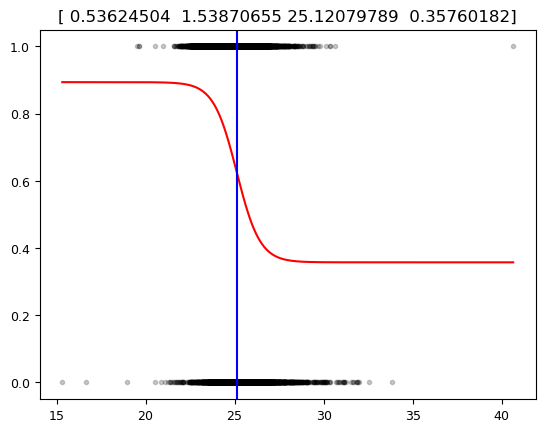

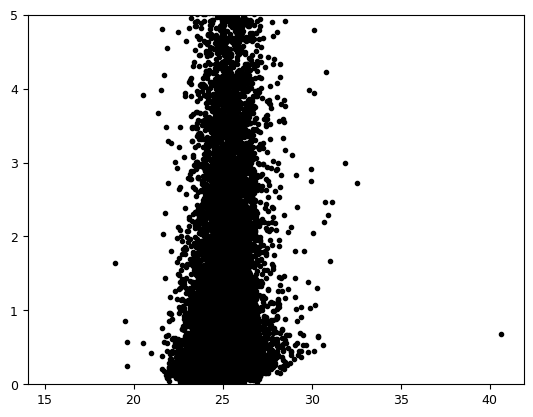

DEPTH:  25.120797889594655
calibration size:  392


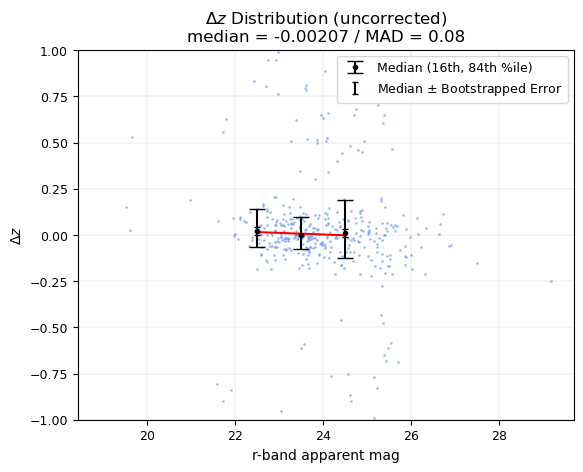

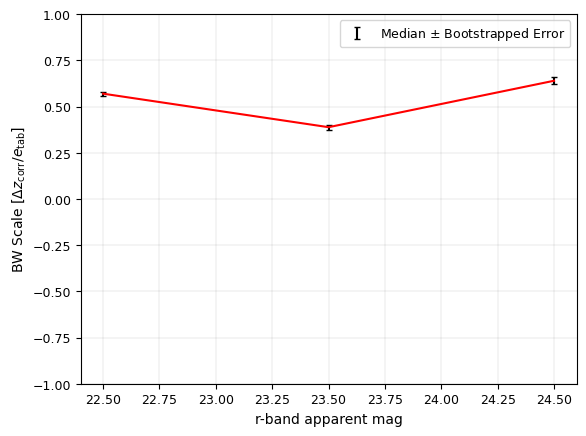

WORKING ON SUBSAMPLE 12 ----------------------------


/afs/cas.unc.edu/users/z/h/zhutchen/.conda/envs/astro2/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


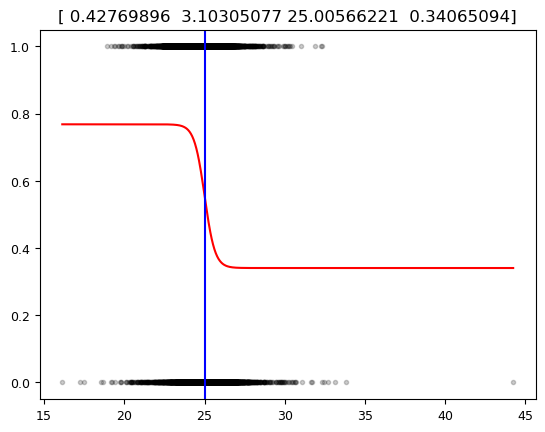

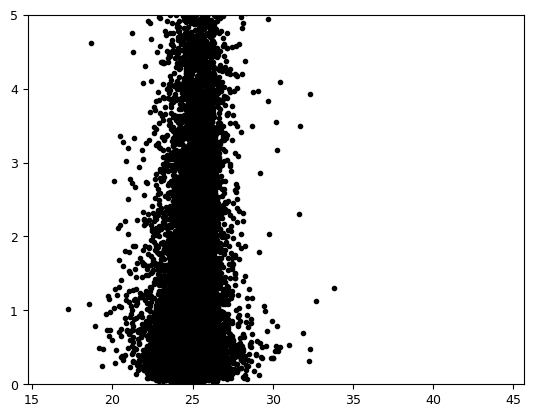

DEPTH:  25.005662210574993
calibration size:  436


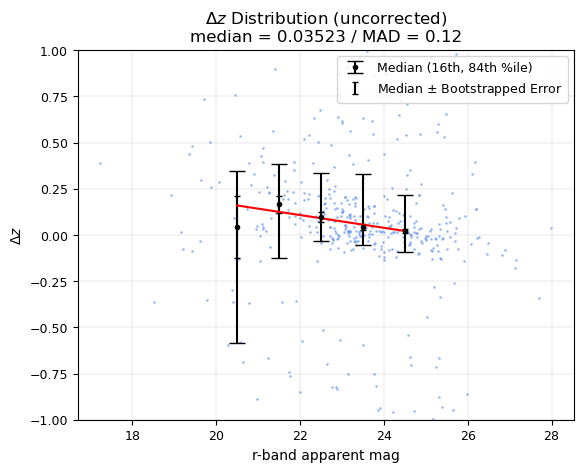

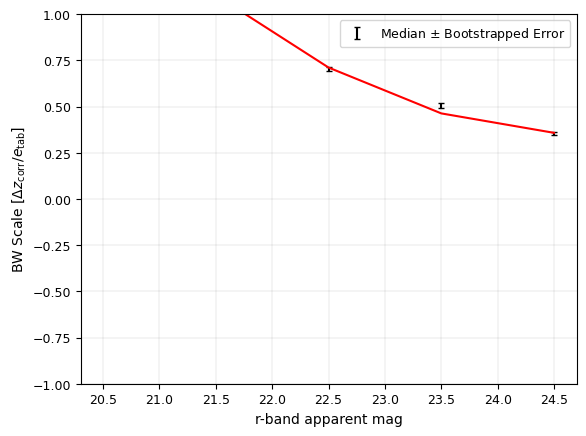

WORKING ON SUBSAMPLE 13 ----------------------------


/afs/cas.unc.edu/users/z/h/zhutchen/.conda/envs/astro2/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


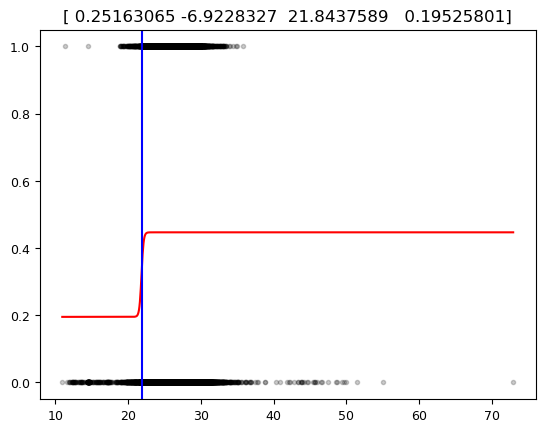

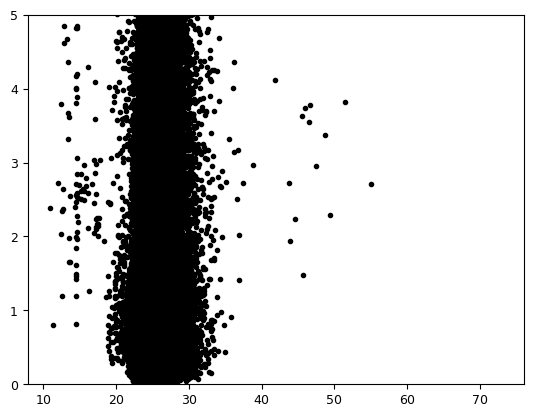

DEPTH:  21.843758904277323
calibration size:  2561


/tmp/ipykernel_908259/3479680838.py:17: RankWarning: Polyfit may be poorly conditioned
  zphot_correction_function = correct_photz_values(photz_for_cal, specz_for_cal, rmag_for_cal, bins, depth, showplots)


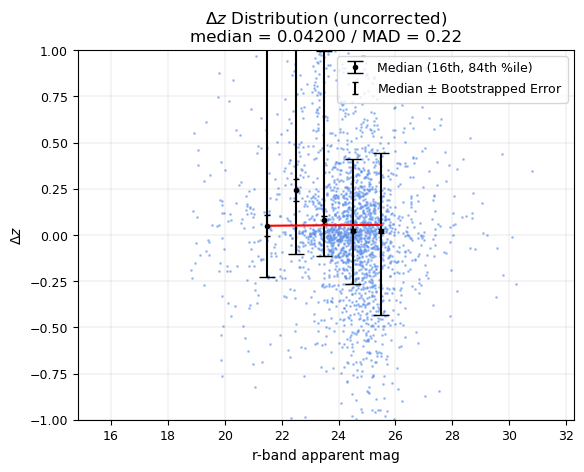

/tmp/ipykernel_908259/3479680838.py:23: RankWarning: Polyfit may be poorly conditioned
  etab_correction_function = correct_photz_errors(photzcorr_for_cal, photzerr_for_cal, specz_for_cal, rmag_for_cal, bins, depth, showplots)


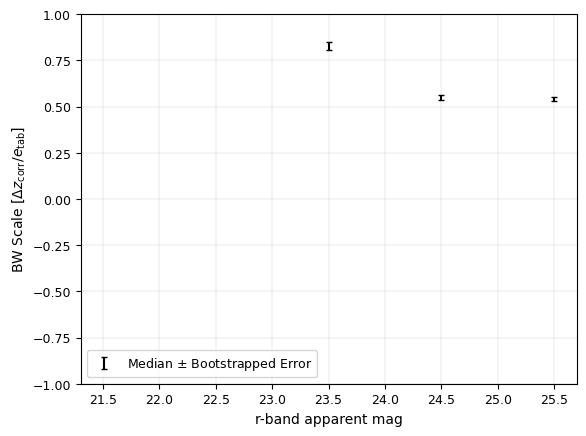

In [8]:
for ii in range(len(subsamples)):
    #get_photoz_depth(subsamples[ii].zphot, subsamples[ii].Qz, subsamples[ii].mag_R_VOICE)
    print("WORKING ON SUBSAMPLE {} ----------------------------".format(ii))
    zphotcorr, etabcorr = get_photz_corrections(subsamples[ii].zphot, subsamples[ii].Qz, subsamples[ii].zphoterr, subsamples[ii].combinedzspec, \
                                 subsamples[ii].mag_R_VOICE, showplots=True)
    subsamples[ii].loc[:,'zphotcorr'] = zphotcorr
    subsamples[ii].loc[:,'zphoterrcorr'] = etabcorr

# Recombine Dataset

In [9]:
recombined = pd.concat(subsamples)

In [10]:
recombined[['zphot','zphoterr','zphotcorr','zphoterrcorr','combinedzspec','combinedzspecerr']]

,zphot,zphoterr,zphotcorr,zphoterrcorr,combinedzspec,combinedzspecerr
1,0.010,0.022091,0.055733,0.010369,0.12082,0.001457
5,0.072,0.099161,0.078708,0.029597,0.11000,0.005550
14,0.030,0.026926,0.019850,0.007448,0.00031,0.005000
15,0.010,0.120702,0.010931,0.034696,0.06700,0.005335
23,0.072,0.062936,0.071515,0.017957,0.10800,0.005540
...,...,...,...,...,...,...
53893,NaN,NaN,NaN,NaN,0.19365,0.001552
53894,NaN,NaN,NaN,NaN,0.09944,0.001429
53895,NaN,NaN,NaN,NaN,0.46344,0.001902
53896,NaN,NaN,NaN,NaN,0.06685,0.001387


In [11]:
tractorid = np.array(recombined.Tractor_ID)
sel = pd.isna(tractorid)
tractorid[sel] = 'none'
tractorid = tractorid.astype(str)
print(tractorid)
recombined.loc[:,'Tractor_ID'] = recombined['Tractor_ID'].astype(str)

['463182' '242212' '485894' ... 'none' 'none' 'none']


In [12]:
recombined = recombined.set_index('Tractor_ID')

#### Make Figure for Paper 3

In [13]:
tmp = deepcopy(subsamples[5])
tmp = tmp[(~tmp.zphot.isna()) & (~tmp.zphotcorr.isna()) & (~tmp.combinedzspec.isna()) & (~tmp.mag_R_VOICE.isna())]

In [14]:
tmp[['zphot','zphoterr','zphotcorr','zphoterrcorr','mag_R_VOICE']]

,zphot,zphoterr,zphotcorr,zphoterrcorr,mag_R_VOICE
6,0.534,0.129139,0.565920,0.029803,21.434061
16,0.534,0.170751,0.565989,0.039440,21.440107
37,0.534,0.096213,0.564503,0.021852,21.309370
40,0.534,0.097944,0.561229,0.021693,21.021217
52,0.565,0.138924,0.618403,0.052443,23.324909
...,...,...,...,...,...
480033,0.504,0.078390,0.534682,0.017837,21.325129
490312,0.580,0.060216,0.639442,0.027068,23.856495
502147,0.565,0.105380,0.606263,0.028831,22.256447
516419,0.504,0.059481,0.550497,0.018540,22.717062


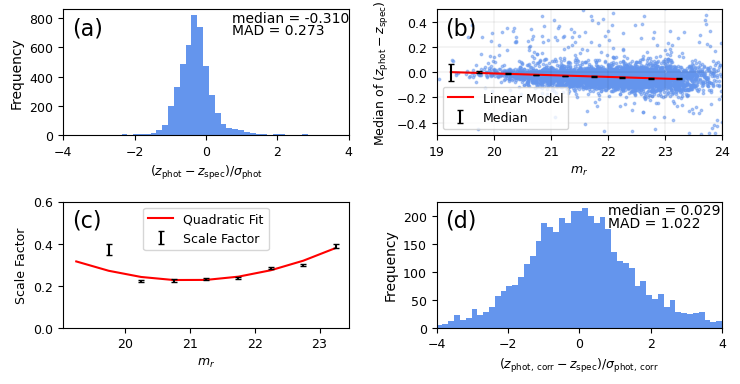

In [15]:
fig, axs = plt.subplots(ncols=2,nrows=2, figsize=(doublecolsize[0],0.9*doublecolsize[1]))
bv = np.linspace(-4,4,50)
val=(tmp.zphot-tmp.combinedzspec)/tmp.zphoterr
axs[0][0].hist(val, color='cornflowerblue',bins=bv)#bv)
axs[0][0].annotate(xy = (0.59,0.9), xycoords='axes fraction', text=r'median = '+'{:0.3f}'.format(np.median(val)))
axs[0][0].annotate(xy = (0.59,0.8), xycoords='axes fraction', text=r'MAD = '+'{:0.3f}'.format(mad(val)))
axs[0][0].set_ylabel("Frequency")
axs[0][0].set_xlabel(r'$(z_{\rm phot} - z_{\rm spec})/\sigma_{\rm phot}$', fontsize = 9)
axs[0][0].set_xlim(-4,4)

#print(np.nanmedian(np.abs(tmp.zphot-tmp.combinedzspec)))
correct_photz_values(tmp.zphot,tmp.combinedzspec,tmp.mag_R_VOICE,np.arange(19,24,0.5),24.66,showplots=axs[0][1])
axs[0][1].set_ylabel(r'Median of $(z_{\rm phot} - z_{\rm spec})$', fontsize = 9)
axs[0][1].set_xlabel(r'$m_r$', fontsize = 9)
axs[0][1].set_xlim(19,24)
axs[0][1].set_ylim(-0.5,0.5)

correct_photz_errors(tmp.zphotcorr, tmp.zphoterr, tmp.combinedzspec, tmp.mag_R_VOICE, np.arange(19,24,0.5), 24.66, showplots=axs[1][0])
axs[1][0].set_ylabel(r'Scale Factor', fontsize = 9)
axs[1][0].set_xlabel(r'$m_r$', fontsize = 9)
axs[1][0].set_ylim(0,0.6)


########################

val = (tmp.zphotcorr-tmp.combinedzspec)/tmp.zphoterrcorr
axs[1][1].hist(val, color='cornflowerblue',bins=bv)#bv)
#print(np.nanmedian(np.abs(tmp.zphotcorr-tmp.combinedzspec)))
axs[1][1].annotate(xy = (0.6,0.9), xycoords='axes fraction', text=r'median = '+'{:0.3f}'.format(np.median(val)))
axs[1][1].annotate(xy = (0.6,0.8), xycoords='axes fraction', text=r'MAD = '+'{:0.3f}'.format(mad(val)))
axs[1][1].set_xlim(-4,4)
axs[1][1].set_ylabel("Frequency")
axs[1][1].set_xlabel(r'$(z_{\rm phot,\, corr} - z_{\rm spec})/\sigma_{\rm phot,\, corr}$', fontsize = 9)

letters = 'abcd'

for ii,ax in enumerate(axs.flatten()):
    ax.annotate(xy=(0.03,0.8),xycoords='axes fraction', text='({})'.format(letters[ii]), fontsize=16)
    ax.set_rasterization_zorder(99)

plt.tight_layout()
plt.savefig("../figures/LADUMA_zphot_corr.pdf",dpi=300)
plt.show()

# Calculate absolute magnitudes 

In [16]:
from speclite import filters
import astropy.units as u
from scipy.integrate import trapezoid, simpson
from scipy.interpolate import interp1d
def get_abs_mag(tractorID, xmmservs_cat, xmmservs_seds):
    try:
        obsv_wavelength = np.array(xmmservs_seds[str(tractorID)]['wavelength'])*1000. # 1000 nm/micron
        zz = xmmservs_cat.loc[tractorID,'bestoverallredshift'] ## changed from bestoverallredshift
        #theirzz = xmmservs_cat.loc[tractorID,'redshift']
        rest_wavelength = obsv_wavelength / (1+zz)
        obsv_specific_lum = np.array(xmmservs_seds[str(tractorID)]['L_lambda_total'])
        obsv_specific_lum *= (float(cosmo.luminosity_distance(zz).to_value()) / float(cosmo.luminosity_distance(xmmservs_cat.loc[tractorID,'redshift']).to_value()))**2.
        rband = filters.load_filter('sdss2010-r')
        rbandwavelength=np.array(rband.wavelength)*0.1 # 0.1 nm per AA
        rbandresponse=np.array(rband.response)
        rbandresponseinterp = interp1d(rbandwavelength,rbandresponse,bounds_error=False,fill_value=0)

        # plt.figure()
        # plt.plot(obsv_wavelength, obsv_specific_lum,'k',label='Observed-Frame Wavelength')
        # plt.plot(rest_wavelength, obsv_specific_lum,'r',label='Rest-Frame wavelength')
        # #plt.xscale('log')
        # plt.yscale('log')
        # plt.xlabel(r"$\lambda$ [nm]")
        # plt.ylabel(r"Specific Luminosity $L_\lambda$ [W/nm]")
        # plt.ylim(1e33,0.2e35)
        # plt.xlim(400,900)
        # plt.legend(loc='best')
        # plt.show()

        Lsun = 3.846e26
        W_per_ergss = 1e-7
        cm_per_Mpc = 3.086e24
        #dist_cm = (3e5*zz)/70. * cm_per_Mpc
        dist_cm = 1e-5 * cm_per_Mpc
        nm_per_AA = 0.1 # nm/AA
        rbandzeropoint_flambda = 278e-11 # ergs/s/cm2/AA
        rbandzeropoint_Llambda = rbandzeropoint_flambda * 4 * np.pi * dist_cm * dist_cm # ergs/s/AA
        rbandzeropoint_Llambda = rbandzeropoint_Llambda * W_per_ergss # W/AA
        rbandzeropoint_Llambda = rbandzeropoint_Llambda / nm_per_AA
        zeropointC = 2.5*np.log10(trapezoid(rbandzeropoint_Llambda*rbandresponseinterp(rest_wavelength),rest_wavelength))

        integrand = (obsv_specific_lum)*rbandresponseinterp(rest_wavelength)
        Lr = trapezoid(integrand,rest_wavelength)
        MM = (-2.5*np.log10(Lr)+zeropointC)
    except KeyError:
        MM = -999
        print("KeyError Warning: failed on tractorID {} (SED not found and/or no phometry or redshift)".format(tractorID))
    return MM

In [17]:
recombined.zphot.isna().any()

True

In [18]:
bestredshift = np.where(~np.isnan(recombined.combinedzspec), recombined.combinedzspec, recombined.zphotcorr)
bestredshifterr = np.where(~np.isnan(recombined.combinedzspec), recombined.combinedzspecerr, recombined.zphoterrcorr)
recombined.loc[:,'bestoverallredshift'] = bestredshift
recombined.loc[:,'bestoverallredshifterr'] = bestredshifterr
RAall = np.where(~np.isnan(recombined.RA_zspecfile), recombined.RA_zspecfile, recombined.RA)
DECall = np.where(~np.isnan(recombined.DEC_zspecfile), recombined.DEC_zspecfile, recombined.DEC)
recombined.loc[:,'RAall'] = RAall
recombined.loc[:,'DECall'] = DECall

In [19]:
# get_abs_mag('691802',recombined,seds)

In [20]:
import h5py
seds = h5py.File('./zou/seds/wcdfs/models_gal_wcdfs.h5', 'r')

In [21]:
def wrapper(tractorID):
    try:
        x = recombined.loc[tractorID,'mag_R_VOICE']
    except ValueError:
        assert False, "value error for tractorID {}".format(x)
        
    if tractorID==np.nan or tractorID=='nan' or pd.isna(tractorID):
        return -999

    if pd.isna(x) or x==0:
        return -999
    else:
        return get_abs_mag(tractorID, recombined, seds)

In [22]:
from pathos.multiprocessing import ProcessingPool

In [23]:
pool=ProcessingPool(50)
absrmag = pool.map(wrapper, recombined.index, daemon=True)
#absrmag = pool.map(wrapper, ['547469'], daemon=True)
#get_abs_mag('59723',recombined,seds)
# absrmag = np.zeros(len(recombined))
# for ii,tid in enumerate(recombined.index):
#     print(tid)
#     absrmag[ii]=wrapper(tid)
#     print('---')

KeyError Warning: failed on tractorID 43814 (SED not found and/or no phometry or redshift)
KeyError Warning: failed on tractorID 44039 (SED not found and/or no phometry or redshift)
KeyError Warning: failed on tractorID 123109 (SED not found and/or no phometry or redshift)
KeyError Warning: failed on tractorID 44093 (SED not found and/or no phometry or redshift)
KeyError Warning: failed on tractorID 713399 (SED not found and/or no phometry or redshift)
KeyError Warning: failed on tractorID 196178 (SED not found and/or no phometry or redshift)
KeyError Warning: failed on tractorID 196547 (SED not found and/or no phometry or redshift)
KeyError Warning: failed on tractorID 196573 (SED not found and/or no phometry or redshift)
KeyError Warning: failed on tractorID 196824 (SED not found and/or no phometry or redshift)
KeyError Warning: failed on tractorID 243716 (SED not found and/or no phometry or redshift)
KeyError Warning: failed on tractorID 243848 (SED not found and/or no phometry or r

In [25]:
absrmag

[-16.854682773530044,
 -21.214622845778337,
 -999,
 -20.3804275348364,
 -21.644699259030745,
 -999,
 -20.78743114195251,
 -20.354346009459206,
 -19.60898326965774,
 -1.5612714574105695,
 -19.75627148307609,
 -20.786946712174682,
 -999,
 -17.837009092233288,
 -16.27851961395406,
 -19.900495892554844,
 -999,
 -20.945953105720264,
 -11.498634571736588,
 -10.190727609146819,
 -17.043029160561005,
 -21.76805132588352,
 -999,
 -999,
 -16.793788955293266,
 -0.9107611426423716,
 -18.7332580805527,
 -18.49898442508261,
 -17.239651587864444,
 -999,
 -21.27289234486379,
 -17.42064787919216,
 -999,
 -19.824658099213096,
 -9.726802242896952,
 -999,
 -20.62169071818657,
 -19.448951387321387,
 -999,
 -999,
 -24.258093134199,
 -999,
 -999,
 -1.9768759484501999,
 -9.874467323125955,
 -999,
 -999,
 -999,
 -999,
 -18.5702905198725,
 -999,
 -18.74440655816808,
 -999,
 -19.348380649752542,
 -17.361871465015128,
 -999,
 -19.38343315470341,
 -18.16996492181947,
 -16.79331884950254,
 -19.456922581977594,
 -21

In [26]:
seds['59']

<HDF5 group "/59" (20 members)>

In [27]:
recombined.loc['200693',:]

col1                            NaN
ID_zspecfile                    NaN
RA_zspecfile                    NaN
DEC_zspecfile                   NaN
ZCLASS_zspecfile                NaN
                            ...    
zphoterrcorr                    NaN
bestoverallredshift             NaN
bestoverallredshifterr          NaN
RAall                     53.632607
DECall                   -27.875776
Name: 200693, Length: 332, dtype: object

In [28]:
get_abs_mag(200693,recombined,seds)

KeyError Warning: failed on tractorID 200693 (SED not found and/or no phometry or redshift)


-999

In [29]:
recombined.loc[:,'absrmag'] = absrmag

In [30]:
recombined.to_hdf('./zou/xmmservs_laduma_merged.hdf5', key='df')

/tmp/ipykernel_908259/1496985939.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->Index(['NED_NAME_zspecfile', 'refcode_zspecfile', 'NED_TYPE_zspecfile',
       'NED_FLAG_zspecfile', 'zrefcode_zspecfile', 'ID_2_zspecfile',
       'object_name_zspecfile', 'MASKNAME_zspecfile', 'SID_zspecfile',
       'CLASS_ATLAS_zspecfile', 'OBJNAME_6_zspecfile', 'SURVEY_zspecfile',
       'FIELD_zspecfile', 'MASK_zspecfile', 'CLASS_PRIMUS_zspecfile',
       'TARGET_BAND_zspecfile', 'ozdes_id_zspecfile', 'object_types_zspecfile',
       'transient_type_zspecfile', 'comment_zspecfile', 'spmask_obs_zspecfile',
       'det_zspecfile', 'id_iau_zspecfile', 'Tractor_ID_other', 'ztype',
       'leftgoodband', 'rightgoodband'],
      dtype='object')]

  recombined.to_hdf('./zou/xmmservs_laduma_merged.hdf5', key='df')


# Check

/afs/cas.unc.edu/users/z/h/zhutchen/.conda/envs/astro2/lib/python3.10/site-packages/astropy/cosmology/flrw/lambdacdm.py:369: RuntimeWarning: invalid value encountered in sqrt
  return 2 * np.sqrt(x) * hyp2f1(1./6, 1./2, 7./6, -x**3)
/tmp/ipykernel_908259/1244326238.py:2: RuntimeWarning: divide by zero encountered in log10
  checkabsrmag = recombined.mag_R_VOICE+5-5*np.log10(cosmo.luminosity_distance(np.array(recombined.bestoverallredshift)).to_value()*1e6) - recombined.A_R_VOICE
/tmp/ipykernel_908259/1244326238.py:2: RuntimeWarning: invalid value encountered in log10
  checkabsrmag = recombined.mag_R_VOICE+5-5*np.log10(cosmo.luminosity_distance(np.array(recombined.bestoverallredshift)).to_value()*1e6) - recombined.A_R_VOICE


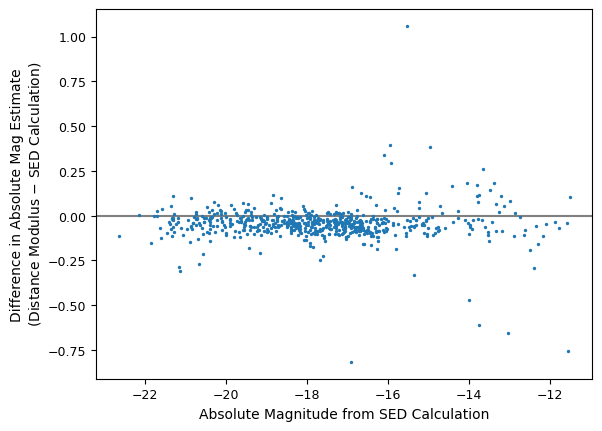

In [31]:
 plt.figure()
checkabsrmag = recombined.mag_R_VOICE+5-5*np.log10(cosmo.luminosity_distance(np.array(recombined.bestoverallredshift)).to_value()*1e6) - recombined.A_R_VOICE
sel = (recombined.bestoverallredshift<0.08) & (recombined.bestoverallredshift>0.01) & ~pd.isna(recombined.bestoverallredshift) & ~pd.isna(recombined.absrmag) & (recombined.absrmag!=-999) & (recombined.flag_star!=1) & ~pd.isna(recombined.combinedzspec)
sc=plt.scatter(recombined.absrmag[sel], checkabsrmag[sel]-recombined.absrmag[sel], s=2)#, c=np.log10(recombined[sel].Qz))
# tx = np.linspace(-5,-25,10) 
# plt.plot(tx,tx,color='k',zorder=0)
plt.xlabel("Absolute Magnitude from SED Calculation")
plt.ylabel("Difference in Absolute Mag Estimate\n(Distance Modulus $-$ SED Calculation)")
plt.axhline(0,color='gray',zorder=0)
#plt.colorbar(sc)
plt.show()

In [32]:
testdata = recombined[sel]
testdata.loc[:,'checkabsrmag'] = checkabsrmag[sel]
testdata['diff'] = np.abs(testdata.absrmag - testdata.checkabsrmag)

/tmp/ipykernel_908259/326301586.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdata.loc[:,'checkabsrmag'] = checkabsrmag[sel]
/tmp/ipykernel_908259/326301586.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdata['diff'] = np.abs(testdata.absrmag - testdata.checkabsrmag)


In [33]:
testdata[['absrmag','checkabsrmag','diff', 'mag_R_VOICE','bestoverallredshift','zphot','zspec','combinedzspec','ZBESTNEW_zspecfile','ZBEST_zspecfile']].sort_values(by='diff')

,absrmag,checkabsrmag,diff,mag_R_VOICE,bestoverallredshift,zphot,zspec,combinedzspec,ZBESTNEW_zspecfile,ZBEST_zspecfile
Tractor_ID,,,,,,,,,,
283898,-17.153666,-17.153536,0.000130,20.574713,0.076380,0.094,NaN,0.076380,0.076380,0.076380
289112,-16.375287,-16.375003,0.000284,19.788481,0.038280,0.010,NaN,0.038280,0.038280,0.038280
412464,-16.767972,-16.767605,0.000367,19.761383,0.045150,0.062,0.045,0.045150,0.045150,0.044718
373886,-18.484821,-18.485729,0.000908,19.249352,0.076920,0.116,0.075,0.076920,0.076920,0.074856
326119,-18.314337,-18.315612,0.001275,19.411194,0.076560,0.010,NaN,0.076560,0.076560,0.076560
...,...,...,...,...,...,...,...,...,...,...
291461,-13.754150,-14.366148,0.611998,23.163012,0.070160,1.548,NaN,0.070160,0.070160,0.070160
305949,-13.040250,-13.696900,0.656650,23.862337,0.071020,0.853,0.071,0.071020,0.071020,0.071020
735775,-11.538764,-12.294087,0.755323,25.409945,0.076000,2.300,0.076,0.076000,0.076000,2.298000


In [34]:
wrapper('547469')

-12.639223890181825

In [35]:
22.8+5-5*np.log10(cosmo.luminosity_distance(2.203).to_value()*1e6)

-23.413699507119286

In [36]:
3e5*0.014/70

60.0

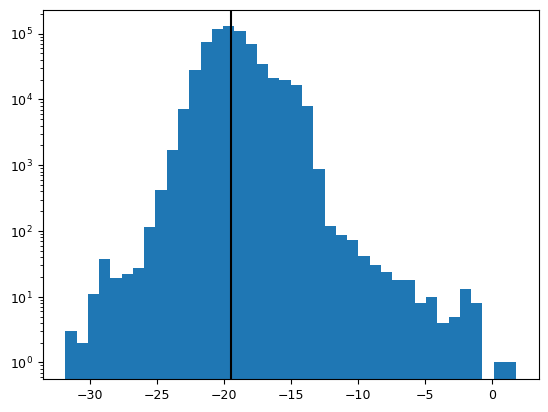

In [37]:
plt.figure()
plt.hist(recombined.absrmag[recombined.absrmag!=-999],bins=40)
plt.axvline(-19.5,color='k')
plt.yscale('log')
plt.show()

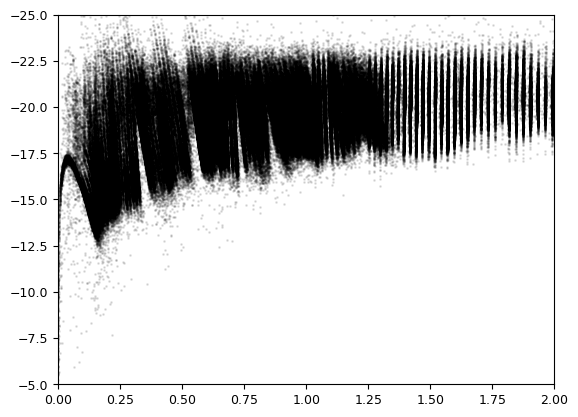

In [38]:
plt.figure()
sel = (recombined.absrmag!=-999)
plt.scatter(recombined.bestoverallredshift[sel], recombined.absrmag[sel], s=1, color='k', alpha=0.1)
plt.gca().invert_yaxis()
plt.xlim(0,2)
plt.ylim(-5,-25)
plt.show()

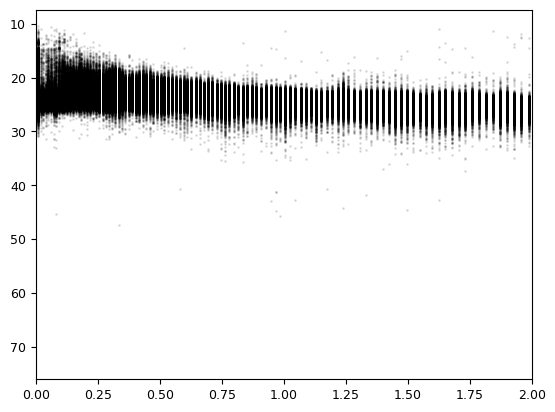

In [39]:
plt.figure()
sel = (recombined.absrmag!=-999)
plt.scatter(recombined.zphot[sel], recombined.mag_R_VOICE[sel], s=1, color='k', alpha=0.1)
plt.gca().invert_yaxis()
plt.xlim(0,2)
plt.show()

In [40]:
[kk for kk in recombined.keys() if ('specfile' in kk) and (kk.startswith('Z'))]

['ZCLASS_zspecfile',
 'ZBEST_zspecfile',
 'ZFLAG_zspecfile',
 'ZWHERE_zspecfile',
 'Z_1_zspecfile',
 'Z_2_zspecfile',
 'ZFLAGS_2_zspecfile',
 'Z_4_zspecfile',
 'Z_ERR_zspecfile',
 'ZHELIO_zspecfile',
 'ZQUALITY_4_zspecfile',
 'Z_6_zspecfile',
 'ZQUALITY_6_zspecfile',
 'Z_7_zspecfile',
 'Z_QUALITY_zspecfile',
 'Z_9_zspecfile',
 'Z_10_zspecfile',
 'Z_11_zspecfile',
 'ZBESTNEW_zspecfile',
 'ZFLAGNEW_zspecfile',
 'ZERR1_zspecfile',
 'ZERR2_zspecfile',
 'ZERR3_zspecfile',
 'ZERR4_zspecfile',
 'ZERR5_zspecfile',
 'ZERR6_zspecfile',
 'ZERR7_zspecfile',
 'ZERR8_zspecfile',
 'ZERR9_zspecfile',
 'ZERR10_zspecfile',
 'ZERR11_zspecfile',
 'ZCONF_zspecfile',
 'ZERRNEW_zspecfile']